<a href="https://colab.research.google.com/github/iamviji/project/blob/master/MainModelKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note:To Checkin

In [2]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 53 (delta 11), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (53/53), done.
project  sample_data
MainModel.ipynb  MainModelWithSingleBERTraining.ipynb  README.md  util.py
     |████████████████████████████████| 1.1MB 6.8MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=1d3b99a833677302be0cd37edbdf24e348cc7e02b3ca22dfa8bfbab9ec8f2fb2
  Stored in directory: /root/.cache/pip/wheels/47/7a/10/e94058ba8b0b6d98bf2719226d18d3dd6056525ad7b984c068
Successfully built pyldpc
     |████████████████████████████████| 51kB 3.6MB/s 


In [3]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

In [4]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [5]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [6]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[0 1 0 ... 1 0 1]
 [1 0 1 ... 0 1 1]
 [0 1 1 ... 0 1 0]
 ...
 [0 1 0 ... 1 0 1]
 [1 1 1 ... 0 0 0]
 [0 1 1 ... 1 1 0]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [7]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.87s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.83s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 5.72s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 7.64s
SNR: 0.000:
 -> BER: 0.61
 -> Total Time: 19.06s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.65s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 3.14s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.68s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 6.15s
SNR: 0.500:
 -> BER: 0.53
 -> Total Time: 15.62s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.33s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.49s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.93s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 5.15s
SNR: 1.000:
 -> BER: 0.45
 -> Total Time: 12.90s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 1.22s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 2.26s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [8]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.76s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.52s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 5.26s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.89s
SNR: 0.000:
 -> BER: 0.62
 -> Total Time: 17.42s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.47s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.86s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.40s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.81s
SNR: 0.500:
 -> BER: 0.54
 -> Total Time: 14.54s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.16s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.31s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.43s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.79s
SNR: 1.000:
 -> BER: 0.44
 -> Total Time: 11.69s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.85s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.82s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [9]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.83s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.64s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 5.48s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 7.31s
SNR: 0.000:
 -> BER: 0.64
 -> Total Time: 18.26s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.37s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.90s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.51s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.92s
SNR: 0.500:
 -> BER: 0.55
 -> Total Time: 14.70s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.14s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.14s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.37s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.64s
SNR: 1.000:
 -> BER: 0.46
 -> Total Time: 11.29s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.95s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.72s
SNR: 1.500 - Iter: 750 - Last 250.0 it

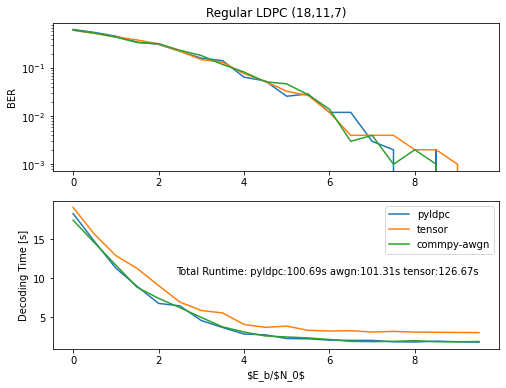

In [10]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [14]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

[[0 1 0 ... 1 1 1]
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 1 1 0]
 ...
 [0 1 0 ... 1 1 0]
 [0 0 1 ... 1 0 1]
 [0 1 0 ... 0 1 1]]
10000


<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [11]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, GaussianNoise
from tensorflow.keras import Model

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

input_message_x = Input(shape=(input_message_length,))
# "encoded" is the encoded representation of the input
enc_layer1 = Dense(CHANEL_SIZE, activation='tanh')(input_message_x)
enc_layer2 = Dense(CHANEL_SIZE, activation='sigmoid')(enc_layer1)
#encoded2 = Dense(CHANEL_SIZE, activation='sigmoid')(encoded1)
# this model maps an input to its encoded representation
enc_layer3 =  enc_layer2 / tf.sqrt(tf.reduce_mean(tf.square(enc_layer2)))
#enc_layer2 = tf.round(enc_layer1)
encoder = Model(input_message_x, enc_layer3)

awgn_channel = GaussianNoise(Snr2Sigma(7.0),input_shape=(CHANEL_SIZE,))

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(CHANEL_SIZE,))
# "decoded" is the lossy reconstruction of the input
dec_layer1 = Dense(CHANEL_SIZE, activation='tanh')(encoded_input)
dec_layer2 = Dense(input_message_length, activation='sigmoid')(dec_layer1)
# this model maps an encoded input to its decoder representation
decoder = Model(encoded_input, dec_layer2)

# this model maps an input to its reconstruction
autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))

In [12]:
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 18)           216         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 18)           342         dense[0][0]                      
__________________________________________________________________________________________________
tf_op_layer_Square (TensorFlowO multiple             0           dense_1[0][0]                    
_______________________________________________________________________________________

In [18]:
import keras

#def custom_losff_fucntion (act, pred):
#  return (tf.reduce_mean(-1*(act * tf.log(pred) + (1-act)*tf.log(1-pred))))

opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
#autoencoder.compile(optimizer=opt, loss=custom_losff_fucntion)
#loss='mean_squared_error'
#for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
for snr in (numpy.arange (0, 10, SNR_STEP_SIZE)):
  sigma = 1.0*Snr2Sigma (snr)
  print ("Training for SNR=", snr, " sigma=", sigma) 
  awgn_channel = GaussianNoise(sigma,input_shape=(CHANEL_SIZE,))
  autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
  opt = keras.optimizers.Adam(learning_rate=0.001)
  autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
  autoencoder.fit(training_input_message, training_input_message,
                #epochs=50, original
                epochs=10,
                batch_size=500,
                shuffle=False,
                validation_data=(input_message, input_message))
  
  

Training for SNR= 0.0  sigma= 1.0
Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 0s 10us/sample - loss: 0.7878 - val_loss: 0.0017
Epoch 2/10
10000/10000 [==============================] - 0s 6us/sample - loss: 0.7647 - val_loss: 0.0020
Epoch 3/10
10000/10000 [==============================] - 0s 6us/sample - loss: 0.7361 - val_loss: 0.0025
Epoch 4/10
10000/10000 [==============================] - 0s 5us/sample - loss: 0.7221 - val_loss: 0.0031
Epoch 5/10
10000/10000 [==============================] - 0s 5us/sample - loss: 0.7005 - val_loss: 0.0040
Epoch 6/10
10000/10000 [==============================] - 0s 5us/sample - loss: 0.6806 - val_loss: 0.0053
Epoch 7/10
10000/10000 [==============================] - 0s 7us/sample - loss: 0.6457 - val_loss: 0.0070
Epoch 8/10
10000/10000 [==============================] - 0s 7us/sample - loss: 0.6333 - val_loss: 0.0095
Epoch 9/10
10000/10000 [==============================] - 0s 6us/sam

In [19]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

#awgn_channel_tx = GaussianNoise(0.5,input_shape=(CHANEL_SIZE,))

#awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
#awgn_noise_std_dev = tf.placeholder(tf.float64)
#awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
#awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)


for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = input_message [i:i+1]
    #print ("input", input_message_xx)
    encoded_message = encoder.predict(input_message_xx)
    #encoded_message = numpy.around(encoded_message > 0.5).astype(int)
    #print(encoded_message)
    #print ("encoded", encoded_message)
    #noised_message = awgn_channel.predict (encoded_message)
    noised_message = commpy.channels.awgn(encoded_message, snr)
    #awgn_channel = GaussianNoise(sigma,input_shape=(CHANEL_SIZE,))
    #noised_message = awgn_channel.predict(encoded_message)
    #noised_message = awgn_layer (encoded_message)
    #awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:0.5, awgn_channel_input:encoded_message[0]})
    #print(noised_message)
    decoded_message = decoder.predict(noised_message)
    decoded_message = numpy.around(decoded_message[0]).astype(int)
    #decoded_message = numpy.around(decoded_message > 0.5).astype(int)
    #print (".")
    #autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
    #decoded_message = autoencoder.predict(input_message_xx)
    #print ("output", decoded_message)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
      #print ("Error")
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.60s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 1.20s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 1.79s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 2.40s
SNR: 0.000:
 -> BER: 0.76
 -> Total Time: 5.99s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.66s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 1.26s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 1.86s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 2.45s
SNR: 0.500:
 -> BER: 0.75
 -> Total Time: 6.22s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.60s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.21s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 1.83s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 2.43s
SNR: 1.000:
 -> BER: 0.72
 -> Total Time: 6.07s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.60s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.20s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

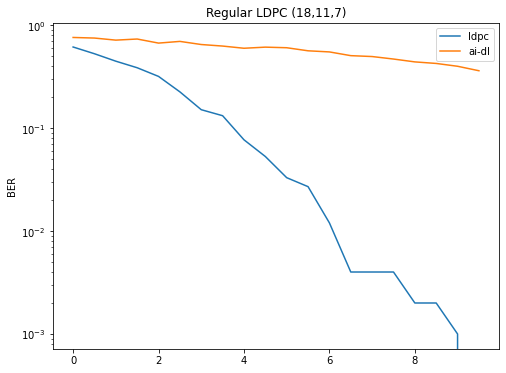

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()